In [112]:
#Importing Libraries we will use for data processing and ML model 

import pandas as pd
from sodapy import Socrata
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import time

In [2]:
# Importing Modules for The GUI

from tkinter import *
from PIL import ImageTk, Image

In [3]:
#importing map distance modules

from geopy.geocoders import Nominatim
from geopy import distance

In [4]:
# Get data from API and load into pandas dataframe

client = Socrata("data.cityofnewyork.us", None)

results = client.get("kxp8-n2sj", limit = 2000000)

taxi_df = pd.DataFrame.from_records(results)
taxi_df.head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2020-01-01T00:28:15.000,2020-01-01T00:33:03.000,1,1.20,1,N,238,239,1,6,3,0.5,1.47,0,0.3,11.27,2.5
1,1,2020-01-01T00:35:39.000,2020-01-01T00:43:04.000,1,1.20,1,N,239,238,1,7,3,0.5,1.5,0,0.3,12.3,2.5
2,1,2020-01-01T00:47:41.000,2020-01-01T00:53:52.000,1,0.60,1,N,238,238,1,6,3,0.5,1,0,0.3,10.8,2.5
3,1,2020-01-01T00:55:23.000,2020-01-01T01:00:14.000,1,0.80,1,N,238,151,1,5.5,0.5,0.5,1.36,0,0.3,8.16,0
4,2,2020-01-01T00:01:58.000,2020-01-01T00:04:16.000,1,0.00,1,N,193,193,2,3.5,0.5,0.5,0,0,0.3,4.8,0


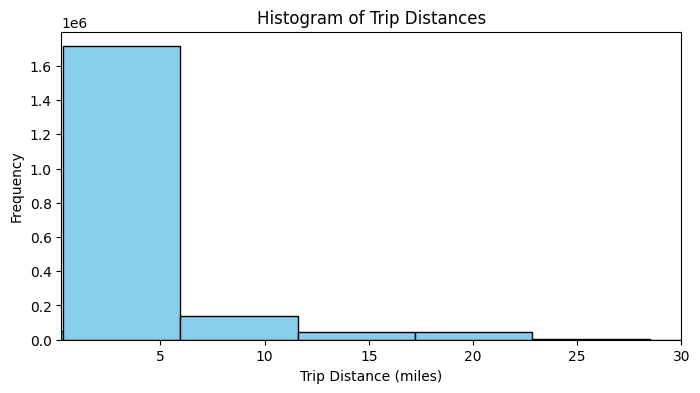

In [5]:
import matplotlib.pyplot as plt

# Converting the trip_distance column to numeric
taxi_df['trip_distance'] = pd.to_numeric(taxi_df['trip_distance'], errors='coerce')

# Ploting a histogram of trip distances
plt.figure(figsize=(8, 4))
plt.hist(taxi_df['trip_distance'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Trip Distances')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.xlim(0.25,30)
plt.show()

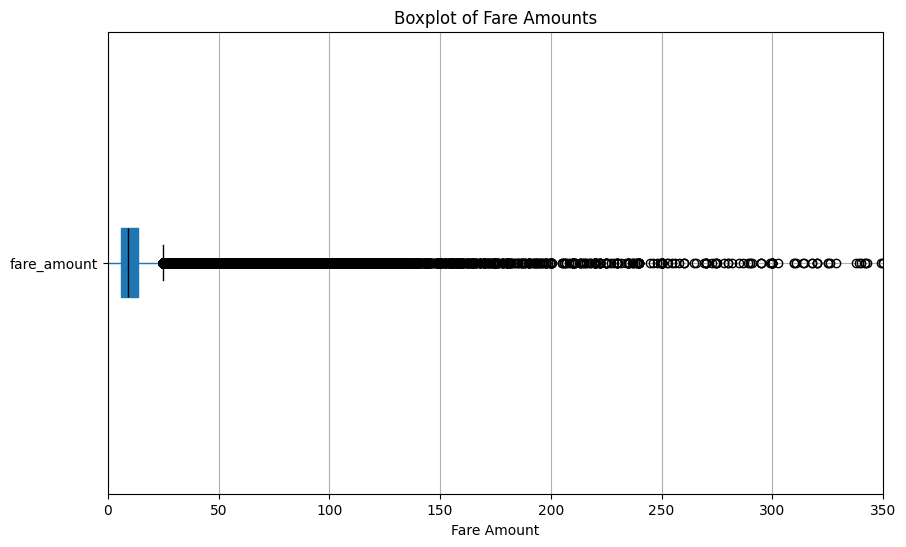

In [6]:
# Convert the fare_amount column to numeric
taxi_df['fare_amount'] = pd.to_numeric(taxi_df['fare_amount'], errors='coerce')

# Plot a boxplot of fare amounts
plt.figure(figsize=(10, 6))
taxi_df.boxplot(column='fare_amount', vert=False, patch_artist=True, medianprops={'color':'black'})
plt.title('Boxplot of Fare Amounts')
plt.xlabel('Fare Amount')
plt.xlim(0,350)
plt.show()

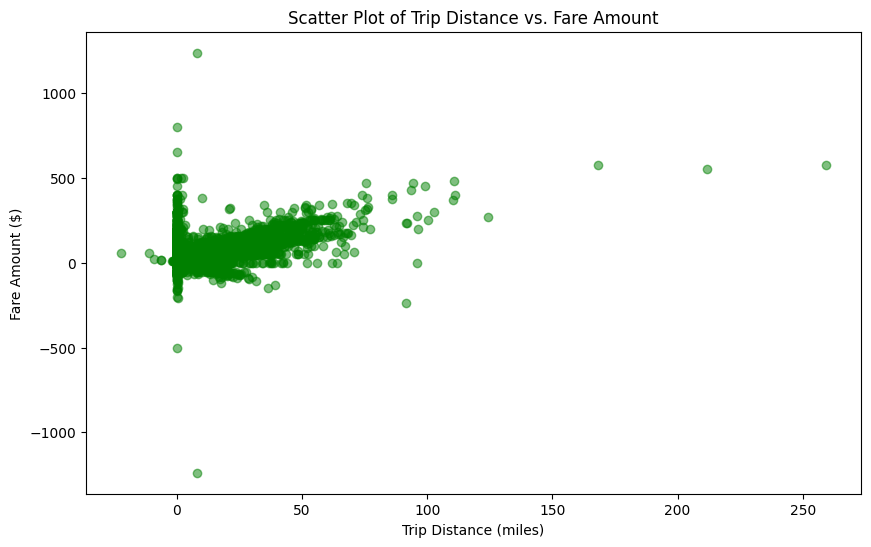

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(taxi_df['trip_distance'], taxi_df['fare_amount'], alpha=0.5, color='green')
plt.title('Scatter Plot of Trip Distance vs. Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.show()

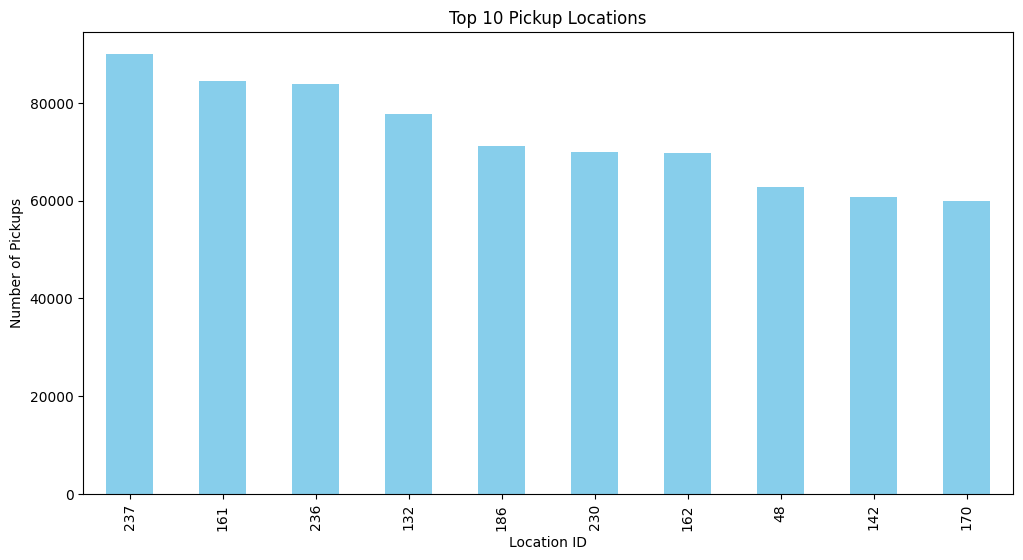

In [8]:
# Ploting a bar plot of the top 10 pickup locations
top_pickup_locations = taxi_df['pulocationid'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
top_pickup_locations.plot(kind='bar', color='skyblue')
plt.title('Top 10 Pickup Locations')
plt.xlabel('Location ID')
plt.ylabel('Number of Pickups')
plt.show()

In [9]:
# Get taxizone lookup table from link

taxi_zone_df = pd.read_csv('https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv')
taxi_zone_df

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [10]:
#Shape of dataframe

taxi_df.shape

(2000000, 18)

In [11]:
#Checking null values

taxi_df.isnull().sum()

vendorid                 4142
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          4142
trip_distance               0
ratecodeid               4142
store_and_fwd_flag       4142
pulocationid                0
dolocationid                0
payment_type             4142
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge        0
dtype: int64

In [12]:
# Dropping rows with null values

taxi_df = taxi_df.dropna()

In [13]:
#Checking Shape after droping null value columns

taxi_df.shape

(1995858, 18)

In [14]:
#Checking data types

taxi_df.dtypes

vendorid                  object
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count           object
trip_distance            float64
ratecodeid                object
store_and_fwd_flag        object
pulocationid              object
dolocationid              object
payment_type              object
fare_amount              float64
extra                     object
mta_tax                   object
tip_amount                object
tolls_amount              object
improvement_surcharge     object
total_amount              object
congestion_surcharge      object
dtype: object

In [15]:
# This command will supress warning raised when chained assignments are used

pd.options.mode.chained_assignment = None

In [16]:
#Converting data types to make it more usefull

taxi_df['vendorid'] = pd.to_numeric(taxi_df['vendorid'])
taxi_df['passenger_count'] = pd.to_numeric(taxi_df['passenger_count'])
taxi_df['trip_distance'] = pd.to_numeric(taxi_df['trip_distance'])
taxi_df['ratecodeid'] = pd.to_numeric(taxi_df['ratecodeid'])
taxi_df['pulocationid'] = pd.to_numeric(taxi_df['pulocationid'])
taxi_df['dolocationid'] = pd.to_numeric(taxi_df['dolocationid'])
taxi_df['payment_type'] = pd.to_numeric(taxi_df['payment_type'])
taxi_df['fare_amount'] = pd.to_numeric(taxi_df['fare_amount'])
taxi_df['extra'] = pd.to_numeric(taxi_df['extra'])
taxi_df['mta_tax'] = pd.to_numeric(taxi_df['mta_tax'])
taxi_df['tip_amount'] = pd.to_numeric(taxi_df['tip_amount'])
taxi_df['tolls_amount'] = pd.to_numeric(taxi_df['tolls_amount'])
taxi_df['improvement_surcharge'] = pd.to_numeric(taxi_df['improvement_surcharge'])
taxi_df['total_amount'] = pd.to_numeric(taxi_df['total_amount'])
taxi_df['congestion_surcharge'] = pd.to_numeric(taxi_df['congestion_surcharge'])
taxi_df['tpep_pickup_datetime'] = pd.to_datetime(taxi_df['tpep_pickup_datetime'])
taxi_df['tpep_dropoff_datetime'] = pd.to_datetime(taxi_df['tpep_dropoff_datetime'])
taxi_df['store_and_fwd_flag'] = taxi_df['store_and_fwd_flag'].astype('category')

In [17]:
taxi_df.dtypes

vendorid                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
ratecodeid                        int64
store_and_fwd_flag             category
pulocationid                      int64
dolocationid                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

In [18]:
taxi_df.dtypes

vendorid                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
ratecodeid                        int64
store_and_fwd_flag             category
pulocationid                      int64
dolocationid                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

In [19]:
# Filtering the data with passengers more than zero and less than nine

taxi_df = taxi_df[taxi_df['passenger_count']>0]
taxi_df = taxi_df[taxi_df['passenger_count']<7]

In [20]:
#Filtering data with Total fare more than zero

taxi_df = taxi_df[taxi_df['total_amount']>0]

In [21]:
taxi_df.head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1,1.2,1,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1,1.2,1,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1,0.6,1,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1,0.8,1,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


In [22]:
## Adding new column called duration (difference between dropoff time and pick up time)
taxi_df['time_difference'] = taxi_df['tpep_dropoff_datetime'] - taxi_df['tpep_pickup_datetime']
taxi_df["time_difference"].head()

0   0 days 00:04:48
1   0 days 00:07:25
2   0 days 00:06:11
3   0 days 00:04:51
4   0 days 00:02:18
Name: time_difference, dtype: timedelta64[ns]

In [23]:
taxi_df["time_difference"] = taxi_df["time_difference"].astype(str)

In [24]:
taxi_df['time_difference'] = taxi_df['time_difference'].str.slice(9)

In [25]:
taxi_df['time_difference'] = taxi_df['time_difference'].str.slice(1)

In [26]:
taxi_df["time_difference"] = taxi_df['time_difference'].str.slice(-2)

In [27]:
taxi_df["time_difference"] = pd.to_numeric(taxi_df["time_difference"])

In [28]:
taxi_df.columns

Index(['vendorid', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'ratecodeid', 'store_and_fwd_flag',
       'pulocationid', 'dolocationid', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'time_difference'],
      dtype='object')

In [29]:
# Creating new columns named weekday number and pickup hour

taxi_df['weekday_num'] = taxi_df.tpep_pickup_datetime.dt.weekday
taxi_df['pickup_hour'] = taxi_df.tpep_pickup_datetime.dt.hour

In [30]:
taxi_df.head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,time_difference,weekday_num,pickup_hour
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1,1.2,1,N,238,239,1,...,3.0,0.5,1.47,0.0,0.3,11.27,2.5,48,2,0
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1,1.2,1,N,239,238,1,...,3.0,0.5,1.50,0.0,0.3,12.30,2.5,25,2,0
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1,0.6,1,N,238,238,1,...,3.0,0.5,1.00,0.0,0.3,10.80,2.5,11,2,0
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1,0.8,1,N,238,151,1,...,0.5,0.5,1.36,0.0,0.3,8.16,0.0,51,2,0
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1,0.0,1,N,193,193,2,...,0.5,0.5,0.00,0.0,0.3,4.80,0.0,18,2,0


In [65]:
# Droping columns which are not necessary for The ML models

ML_dur_df=taxi_df.drop(['vendorid','tpep_pickup_datetime','tpep_dropoff_datetime',
                 'store_and_fwd_flag','ratecodeid','payment_type','total_amount','extra','mta_tax',
                 'improvement_surcharge','congestion_surcharge',"tip_amount", "tolls_amount","fare_amount"], axis=1)

In [66]:
# This command will supress warning raised when chained assignments are used

pd.options.mode.chained_assignment = None

In [67]:
ML_dur_df.head()

,passenger_count,trip_distance,pulocationid,dolocationid,time_difference,weekday_num,pickup_hour
0,1,1.2,238,239,48,2,0
1,1,1.2,239,238,25,2,0
2,1,0.6,238,238,11,2,0
3,1,0.8,238,151,51,2,0
4,1,0.0,193,193,18,2,0


In [68]:
#Spliting the data into test and train
# We are going to use trip distance, PULocationID, DOLocationID, Weekday number and Pickup Hour as the feature elements to predict Taxi fares
# passenger_count,PULocationID,DOLocationID,weekday_num,pickup_hour
x = ML_dur_df.iloc[:, [0,1,2,3,5,6]].values
y = ML_dur_df.iloc[:,4].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state = 7395)

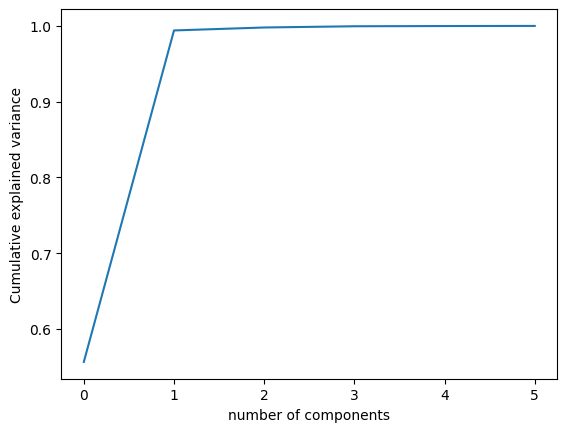

In [69]:
# Uisng PCA to determine necessary number of components for the model to yeild a better result

from sklearn.decomposition import PCA
pca = PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [70]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 55.66), (2, 99.4), (3, 99.79), (4, 99.95), (5, 99.98)]

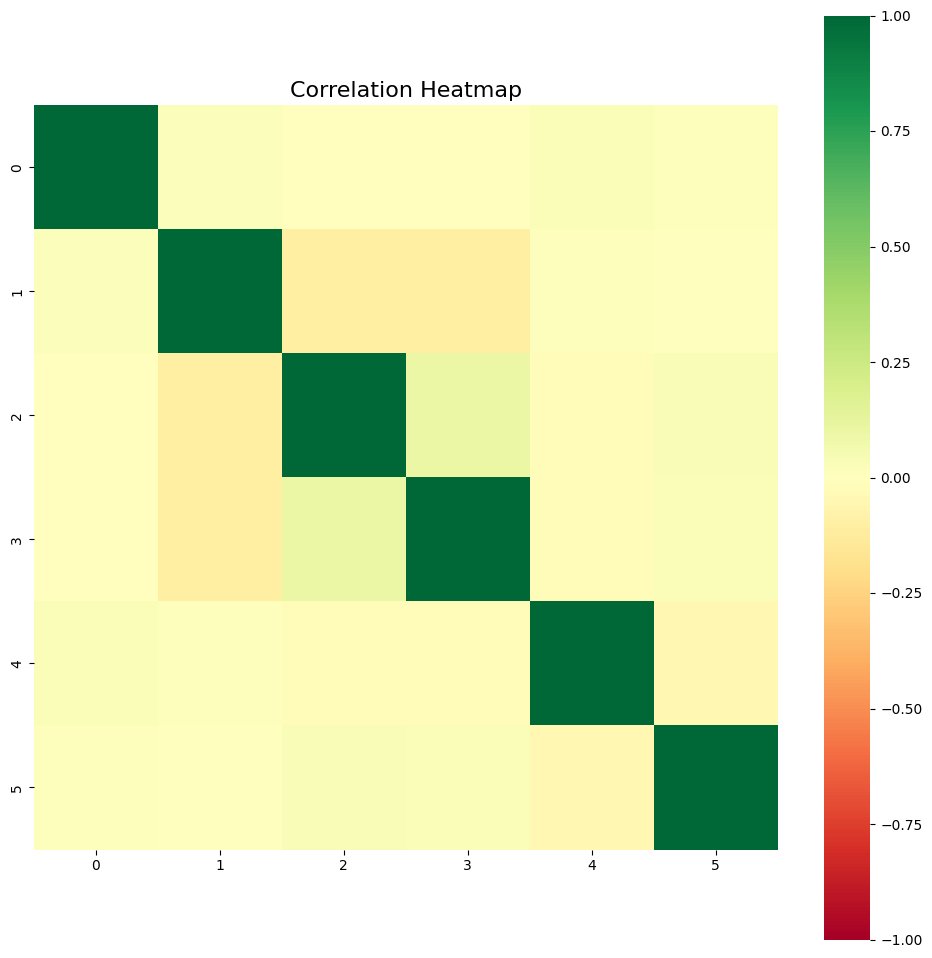

In [71]:
# Plotting the heatmap to understand the correlation between the factors

plt.figure(figsize=(12,12))
corr = pd.DataFrame(x_train[:,0:]).corr()
corr.index = pd.DataFrame(x_train[:,0:]).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [72]:
# Running The Linear regression model

start_time = time.time()
lm_regression = LinearRegression()
lm_regression = lm_regression.fit(x_train, y_train)
end_time = time.time()
lm_time = (end_time - start_time)
print(f"Time taken to train linear regression model : {lm_time} seconds")

Time taken to train linear regression model : 0.2922251224517822 seconds


In [73]:
lm_regression_trips = lm_regression.predict(x_test)
# Generating prediction for Linear Regression model

predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': lm_regression_trips.flatten()})
predictions

,Actual,Predicted
0,17,29.381181
1,45,29.291556
2,49,29.254827
3,19,29.298895
4,42,29.313515
...,...,...
390837,1,29.302222
390838,32,29.519038
390839,56,29.286187
390840,53,29.209446


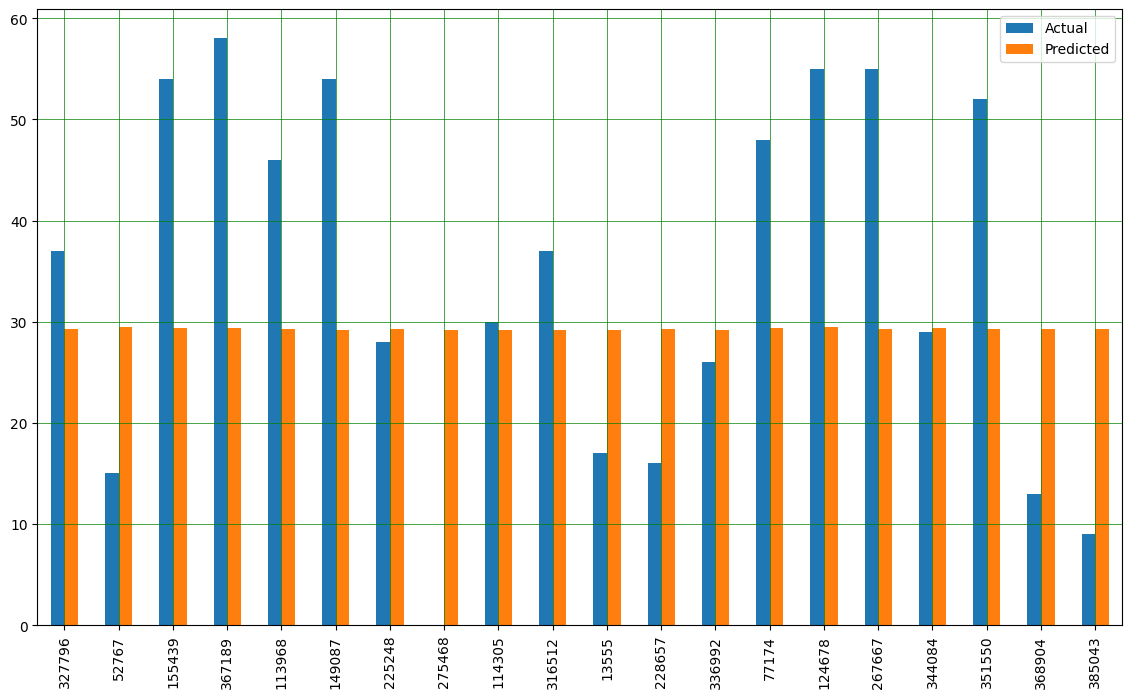

In [74]:
#Plotting Actuall vs Predicted Values

predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [122]:
#Getting The R Squared Value

lm_score = r2_score(y_test, lm_regression_trips)
print(lm_score)

7.448216124950058e-05


In [123]:
# Running the Decision Tree Regressor

start_time = time.time()
dt_regression = DecisionTreeRegressor()
dt_regression = dt_regression.fit(x_train, y_train)
end_time = time.time()
dt_time = (end_time - start_time)
print(f"Time taken to train Decision tree model : {dt_time} seconds")

Time taken to train Decision tree model : 19.693948984146118 seconds


In [124]:
dt_regression_trips = dt_regression.predict(x_test)

In [125]:
# Generating prediction for Decission Tree Regressor model

predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': dt_regression_trips.flatten()})
predictions

,Actual,Predicted
0,17,28.5
1,45,5.0
2,49,3.0
3,19,58.0
4,42,17.0
...,...,...
390837,1,12.5
390838,32,26.0
390839,56,21.0
390840,53,34.0


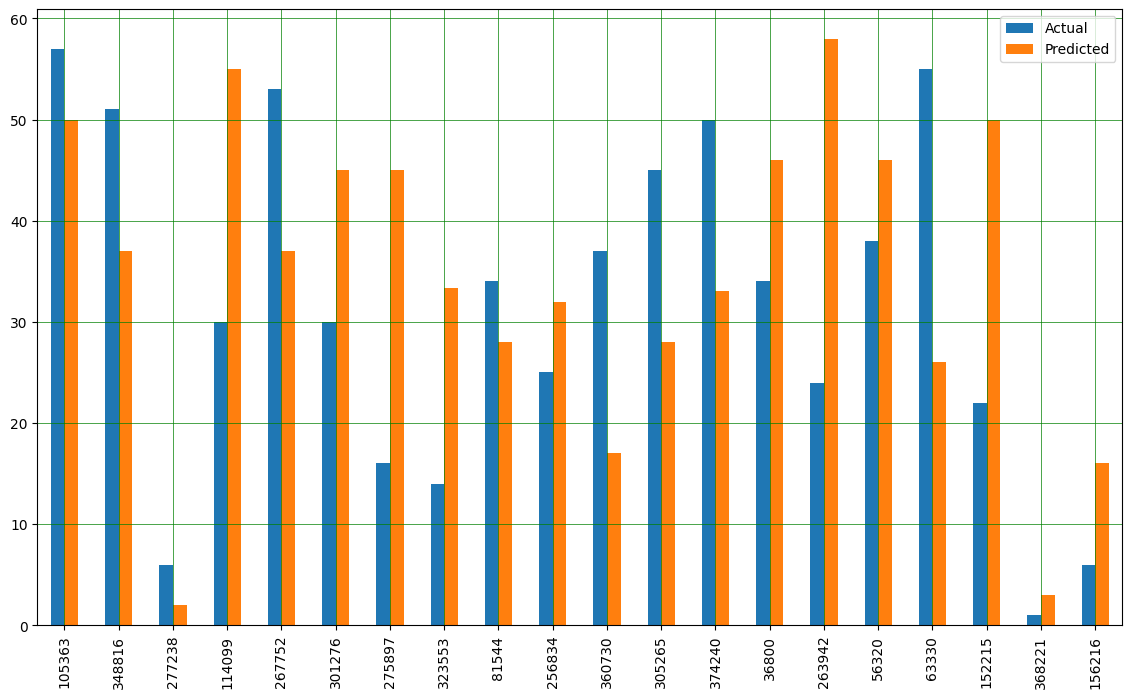

In [126]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [127]:
#Getting The R Squared Value

dt_score = r2_score(y_test, dt_regression_trips)
print(dt_score)

-1.0110138637270536


In [128]:
# Running The AdaBoostRegressor model

start_time = time.time()
ada_regression = AdaBoostRegressor()
ada_regression = ada_regression.fit(x_train, y_train)
end_time = time.time()
ad_time = (end_time - start_time)
print(f"Time taken to train AdaBoost model : {ad_time} seconds")

Time taken to train AdaBoost model : 31.96601915359497 seconds


In [129]:
ada_trips = ada_regression.predict(x_test)

In [130]:
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': ada_trips.flatten()})
predictions

,Actual,Predicted
0,17,29.47777
1,45,29.47777
2,49,29.47777
3,19,29.47777
4,42,29.47329
...,...,...
390837,1,29.47329
390838,32,29.47777
390839,56,29.47777
390840,53,29.47777


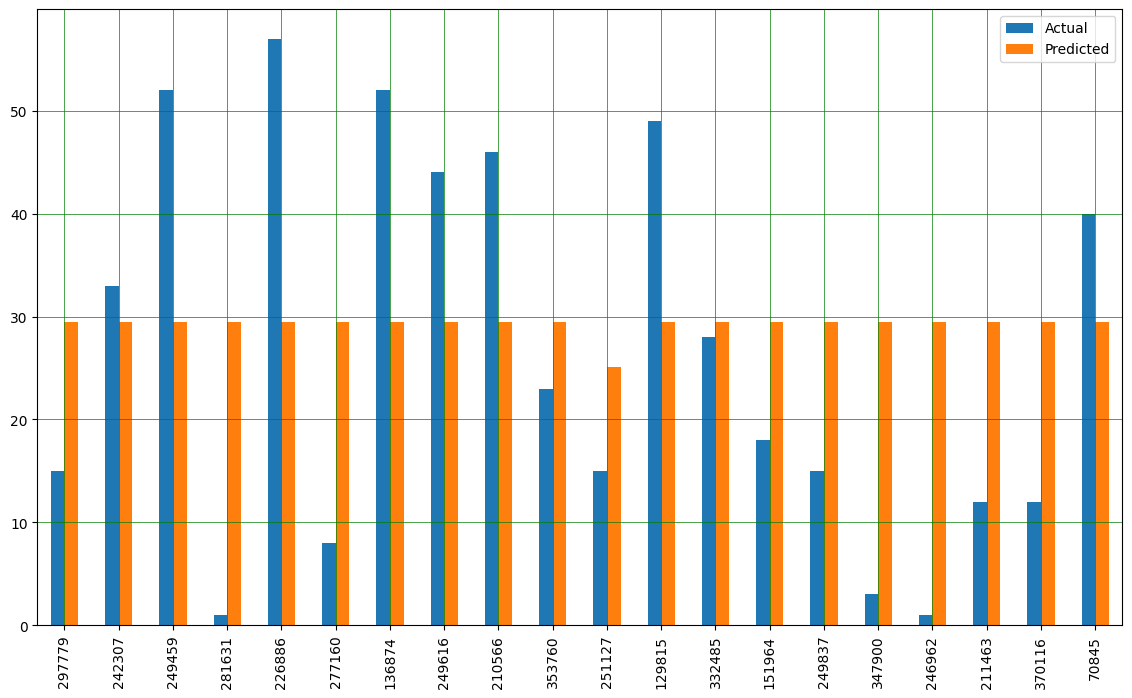

In [131]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [132]:
#Getting The R Squared Value

ad_score = r2_score(y_test, ada_trips)
print(ad_score)

0.006086483696368661


In [133]:
# Running The GradientBoostRegressor model

start_time = time.time()
gd_regression = GradientBoostingRegressor()
gd_regression = gd_regression.fit(x_train, y_train)
end_time = time.time()
gd_time = (end_time - start_time)
print(f"Time taken to train Gradient Boost model : {gd_time} seconds")

Time taken to train Gradient Boost model : 175.3906900882721 seconds


In [134]:
gd_trips = gd_regression.predict(x_test)

In [135]:
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': gd_trips.flatten()})
predictions

,Actual,Predicted
0,17,29.436315
1,45,29.547968
2,49,29.479651
3,19,29.462370
4,42,29.419362
...,...,...
390837,1,29.427579
390838,32,29.516612
390839,56,29.456226
390840,53,29.523252


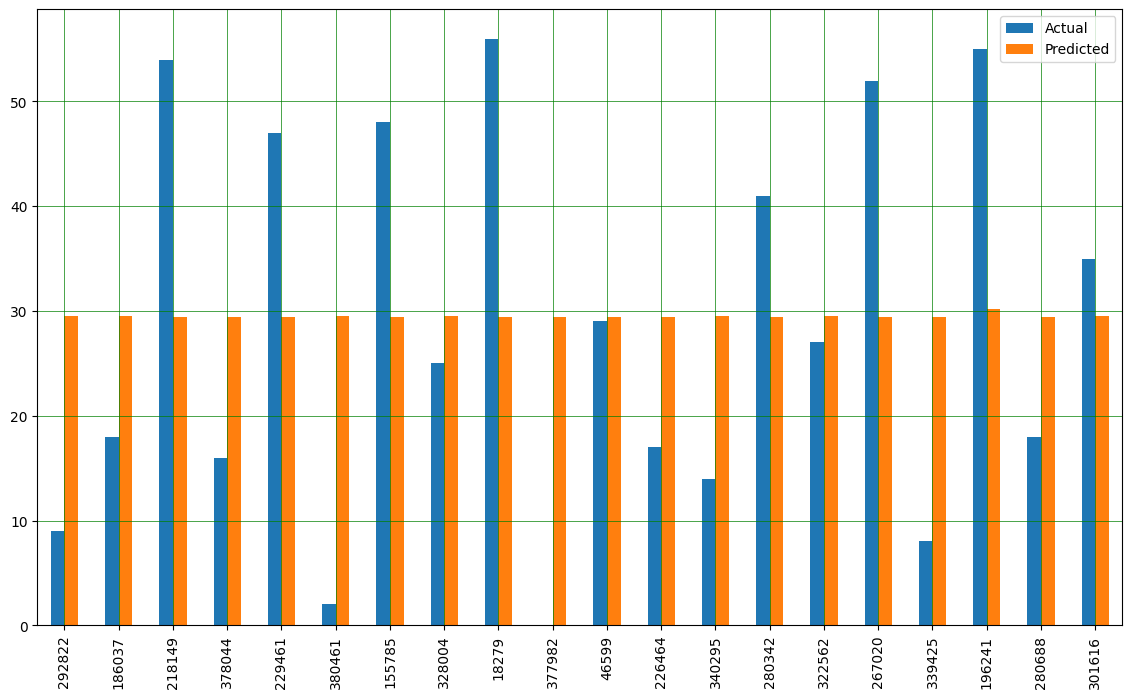

In [136]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [137]:
#Getting The R Squared Value

gd_score = r2_score(y_test, gd_trips)
print(gd_score)

0.006591493413443672


In [138]:
# Running The XGBRegressor model

start_time = time.time()
xgb_regression = XGBRegressor(objective ='reg:squarederror')
xgb_regression = xgb_regression.fit(x_train, y_train)
end_time = time.time()
xgb_time = (end_time - start_time)
print(f"Time taken to train XGBoost  model : {xgb_time} seconds")

Time taken to train XGBoost  model : 5.7103493213653564 seconds


In [139]:
XGB_trips = xgb_regression.predict(x_test)

In [140]:
predictions = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': XGB_trips.flatten()})
predictions

,Actual,Predicted
0,17,29.395296
1,45,29.777456
2,49,29.884382
3,19,29.498297
4,42,29.590609
...,...,...
390837,1,29.545792
390838,32,29.905117
390839,56,28.997890
390840,53,29.313778


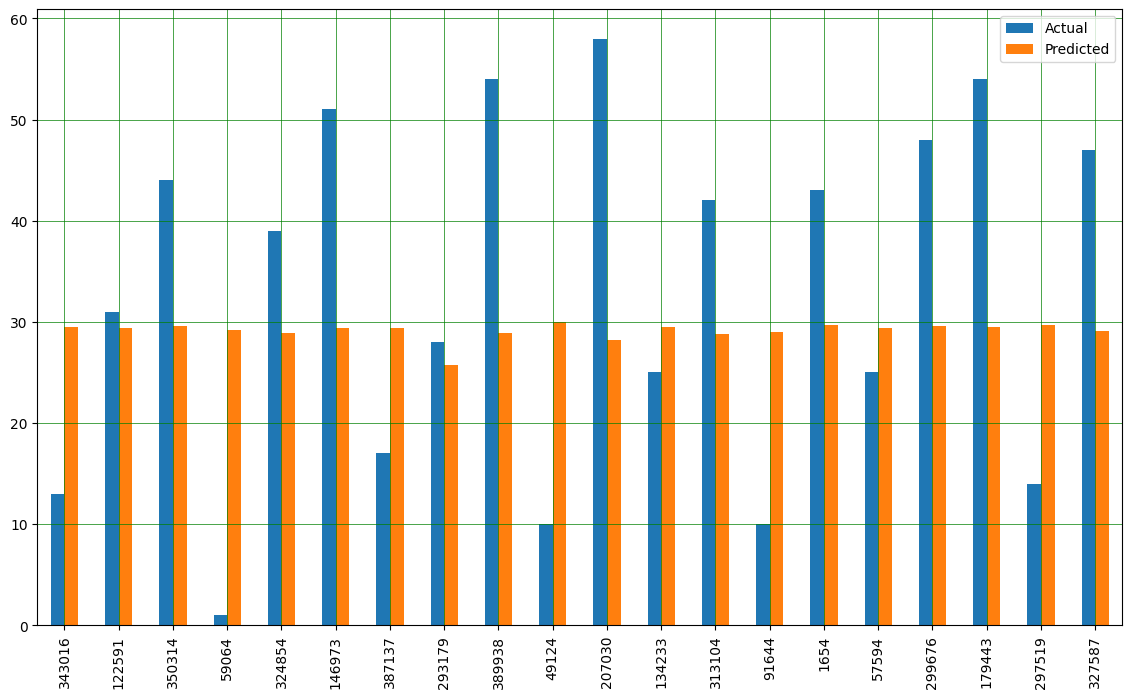

In [141]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [142]:
#Getting The R Squared Value

xgb_score = r2_score(y_test, XGB_trips)
print(xgb_score)

0.005548253987513574


In [143]:
# Creating Accuracy and Time Dataframe

#r2 = [lm_score, dt_score, ad_score, gd_score, xgb_score]
#tm = [lm_time, dt_time, ad_time, gd_time, xgb_time]
#comp = pd.DataFrame({'Time': tm, 'Accu': r2})

r2 = [100 - (lm_score), 100 - (dt_score), 100 - (gd_score), 100 - (xgb_score)]
tm = [lm_time, dt_time, gd_time, xgb_time]
comp = pd.DataFrame({'Time': tm, 'Accu': r2})

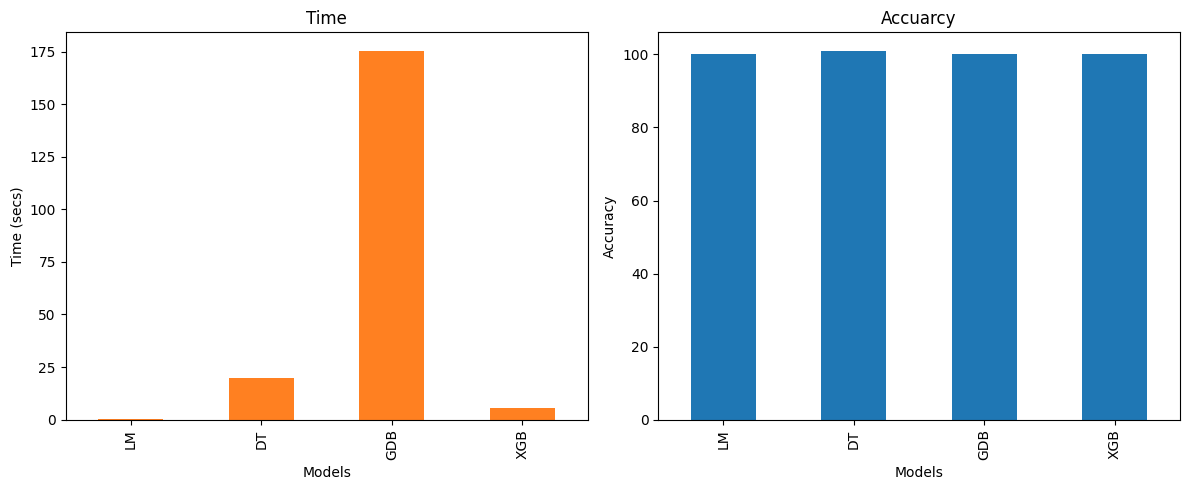

In [144]:
# Comparing All models based on time taken to implement and Accuracy

label = ['LM', 'DT', 'GDB', 'XGB']
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = comp['Time'].plot(kind='bar',title="Time",ax=axes[0],color = (1, 0.5, 0.13))
ax1 = comp['Accu'].plot(kind='bar',title="Accuarcy",ax=axes[1])
ax.set_ylabel("Time (secs)")
ax.set_xlabel('Models')
ax.set_xticklabels(label)
ax1.set_ylabel("Accuracy")
ax1.set_xlabel('Models')
ax1.set_xticklabels(label)
fig.tight_layout()